## Notebook for figures

Please use this notebook to generate any extra figures we need for the writeup (If not already generated in modelling notebooks)

The following figures are included here:

- Images and after preprocessing

## Import packages & Data

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split

from keras import backend as K
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
import gc

seed=1


In [4]:
from google.colab import drive

# This will prompt you to click on a link, sign in to your Google account, and copy a verification code.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# paths
orig_path = '/content/drive/MyDrive/OneDrive_clone/Documents/stats_modules/ST456 (Deep Learning)/final_project/images_training_rev1/images_training_rev1/part_1'
target_path = '/content/drive/MyDrive/OneDrive_clone/Documents/stats_modules/ST456 (Deep Learning)/final_project/training_solutions_rev1.csv'
data_path = '/content/drive/MyDrive/OneDrive_clone/Documents/stats_modules/ST456 (Deep Learning)/final_project/galaxy_bin/compressed_img_target.npz'


In [ ]:
# load cropped, compressed images
loaded_arrays = np.load(data_path)

data = loaded_arrays['images']
target = loaded_arrays['target']

target_df = pd.read_csv(target_path)

print(data.shape, target.shape)
print(target_df.shape)


In [6]:
# 80% train, 20% validation
X_train, X_test, y_train, y_test = train_test_split(
     data, target, test_size=0.2, random_state=42)
X_train.shape, X_test.shape


((49262, 64, 64, 3), (12316, 64, 64, 3))

In [7]:
## Comparing sample from preprocessed image set and original image set
# load sample from original data for comparison (for report)
original_sample , _ = build_dataset(orig_path, n=12, preprocess=False)
preprocessed_sample, _ = build_dataset(orig_path, n=12)
preprocessed_gs = rgb_to_grayscale(preprocessed_sample)
preprocessed_sample.shape
preprocessed_gs.shape
original_sample.shape
byte_count = original_sample.nbytes

Building dataset: 100%|██████████| 12/12 [00:00<00:00, 165.90it/s]


Shape of images array: (12, 424, 424, 3)


Building dataset: 100%|██████████| 12/12 [00:00<00:00, 72.13it/s]

Shape of images array: (12, 64, 64, 3)


## Helper functions

In [19]:
def center_crop(img, crop_size):
    """Center crop the image to the specified size."""
    width, height = img.size
    left = (width - crop_size) // 2
    top = (height - crop_size) // 2
    right = (width + crop_size) // 2
    bottom = (height + crop_size) // 2
    return img.crop((left, top, right, bottom))


def build_dataset(image_path, n = None, preprocess=True, crop_size=210, resize_to=(64, 64)):
    """Load images from the specified directory, center crop them, and then resize."""
    image_files = os.listdir(image_path)
    if n:
      image_files = image_files[:n]

    n_files = len(image_files)

    images = []

    for filename in tqdm(image_files, total=n_files, desc="Building dataset"):
        filepath = os.path.join(image_path, filename)

        with Image.open(filepath) as img:
            if preprocess:
                img = center_crop(img, crop_size)
                print(np.array(img).shape)
                img = img.resize(resize_to)
            img_array = np.array(img)

            images.append(img_array)

    # Convert the list of images into a single NumPy array
    images_array = np.array(images)

    print("Shape of images array:", images_array.shape)
    return images_array, image_files


def build_target(image_files, target_df):
    n_files = len(image_files)

    target_matrix = []
    for fname in tqdm(image_files, total=n_files, desc="Building target"):
        galaxy_id = int(fname.split('.')[0])
        target_ex = target_df.loc[target_df['GalaxyID'] == galaxy_id, target_df.columns != 'GalaxyID'].values[0]
        target_matrix.append(target_ex)

    target_matrix = np.array(target_matrix)

    print("\nShape of target array:", target_matrix.shape)

    return target_matrix


def plot_random_images(dataset, n=6, seed=None, rgb=True):
    plt.figure(figsize=(25, 10))
    length = dataset.shape[0]

    if seed:
        np.random.seed(seed)

    idx_lst = np.random.randint(0, length, n)
    for i, idx in enumerate(idx_lst):
        plt.subplot(n//3, n//2, i+1)
        image = dataset[idx]

        if rgb:
          plt.imshow(image)
        else:
          plt.imshow(image, cmap='gray')

        plt.title(f'Image {idx}\nShape: {image.shape}')
        plt.axis(False)

    plt.tight_layout()
    plt.show()


def plot_images_in_order(dataset, n=6, rgb=True):
    plt.figure(figsize=(25, 10))
    length = dataset.shape[0]

    idx_lst = np.arange(0, n)
    for i, idx in enumerate(idx_lst):
        plt.subplot(n//3, n//2, i+1)
        image = dataset[idx]

        if rgb:
          plt.imshow(image)
        else:
          plt.imshow(image, cmap='gray')
        plt.title(f'Image {idx}\nShape: {image.shape}')
        plt.axis(False)

    plt.tight_layout()
    plt.show()


def rgb_to_grayscale(images):
    # convert RGB to grayscale using the formula: Y = 0.299*R + 0.587*G + 0.114*B
    grayscale_images = np.dot(images[..., :3], [0.299, 0.587, 0.114])
    grayscale_images = np.squeeze(grayscale_images)

    return grayscale_images

## Comparing sample from preprocessed image set and original image set

In [20]:
# load sample from original data for comparison (for report)
original_sample , _ = build_dataset(orig_path, n=12, preprocess=False)
preprocessed_sample, _ = build_dataset(orig_path, n=12)
preprocessed_gs = rgb_to_grayscale(preprocessed_sample)

Building dataset: 100%|██████████| 12/12 [00:00<00:00, 113.16it/s]


Shape of images array: (12, 424, 424, 3)


Building dataset: 100%|██████████| 12/12 [00:00<00:00, 127.55it/s]

(210, 210, 3)
(210, 210, 3)
(210, 210, 3)
(210, 210, 3)
(210, 210, 3)
(210, 210, 3)
(210, 210, 3)
(210, 210, 3)
(210, 210, 3)
(210, 210, 3)
(210, 210, 3)
(210, 210, 3)
Shape of images array: (12, 64, 64, 3)


In [ ]:
preprocessed_sample.shape

(12, 64, 64, 3)

In [8]:
original_sample.shape

(12, 424, 424, 3)

In [9]:
byte_count = original_sample.nbytes

In [10]:
# size of image dataset as a numpy array multiplied by
size = 61578 * (byte_count//12)
print(f"Linearly interpolated size of full dataset as a numpy array: {np.round(size/1e9, 2)}")

Linearly interpolated size of full dataset as a numpy array: 33.21


Processed images (grayscale)


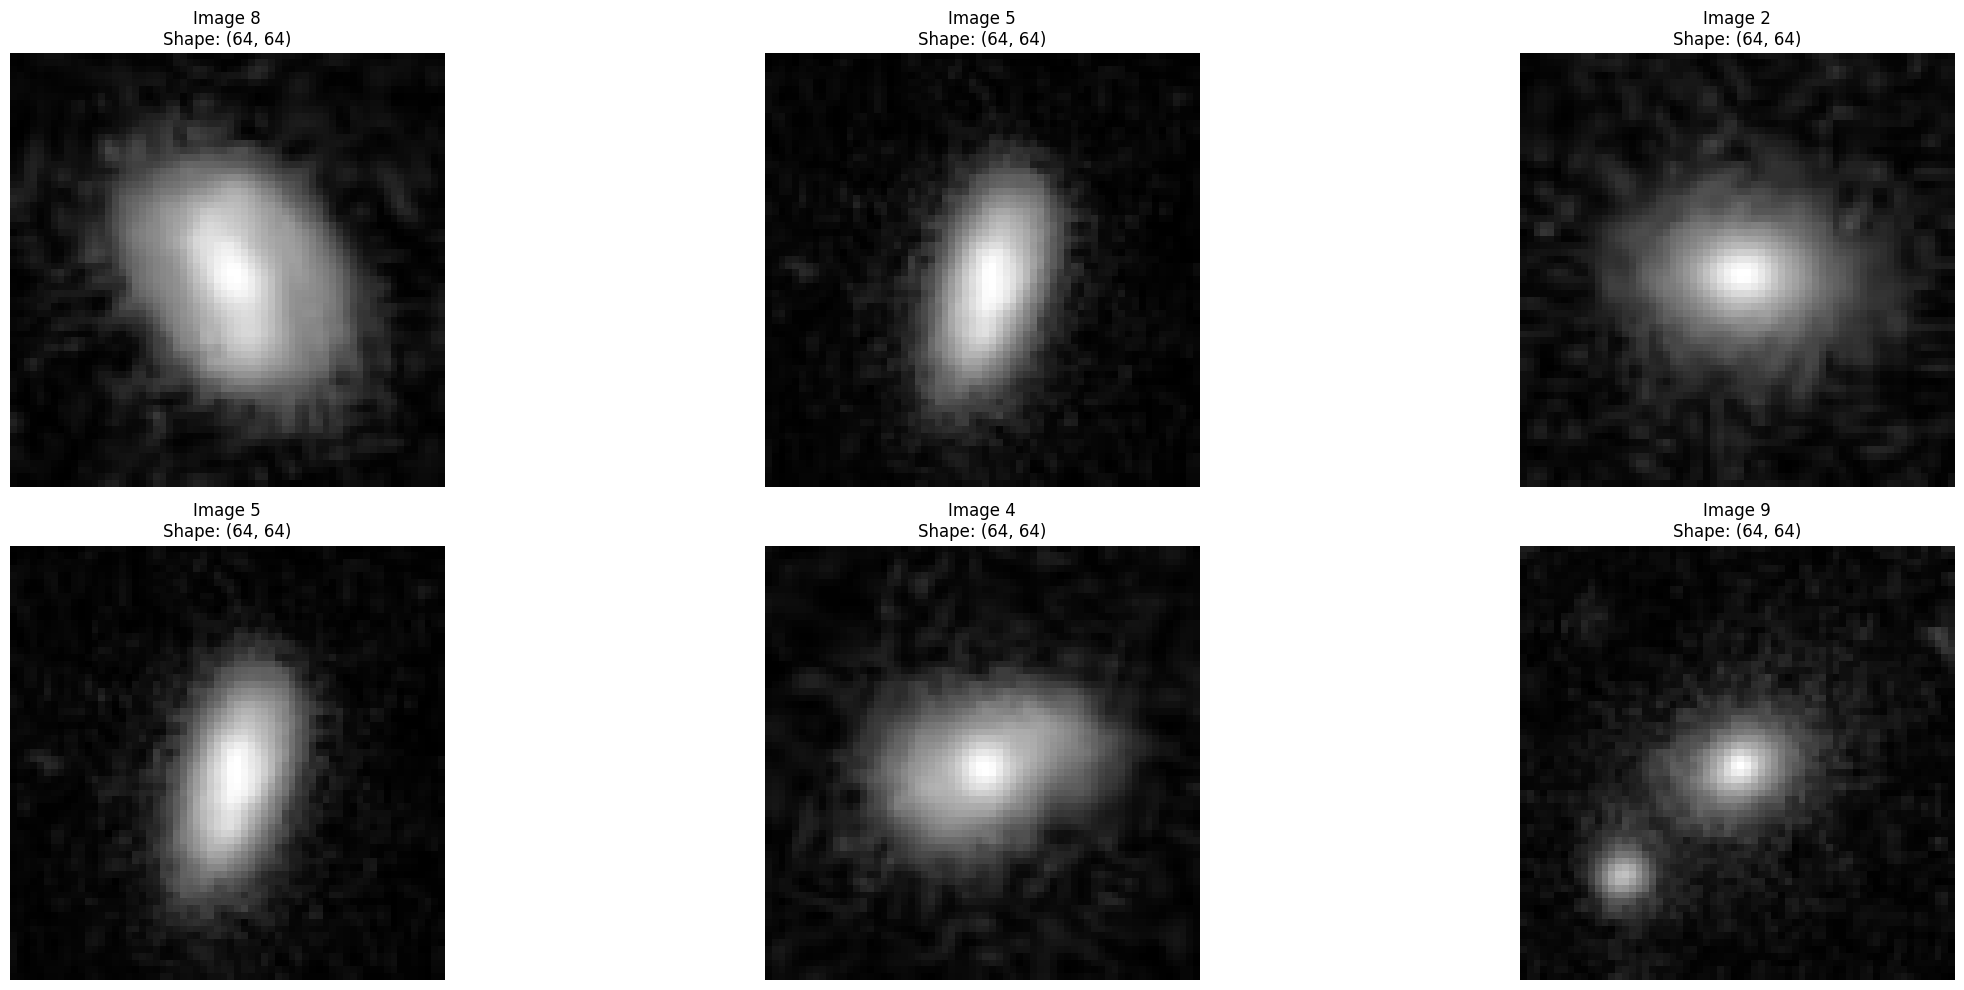

In [ ]:
print("Processed images (grayscale)")
plot_random_images(preprocessed_gs, 6, rgb=False)

Processed images


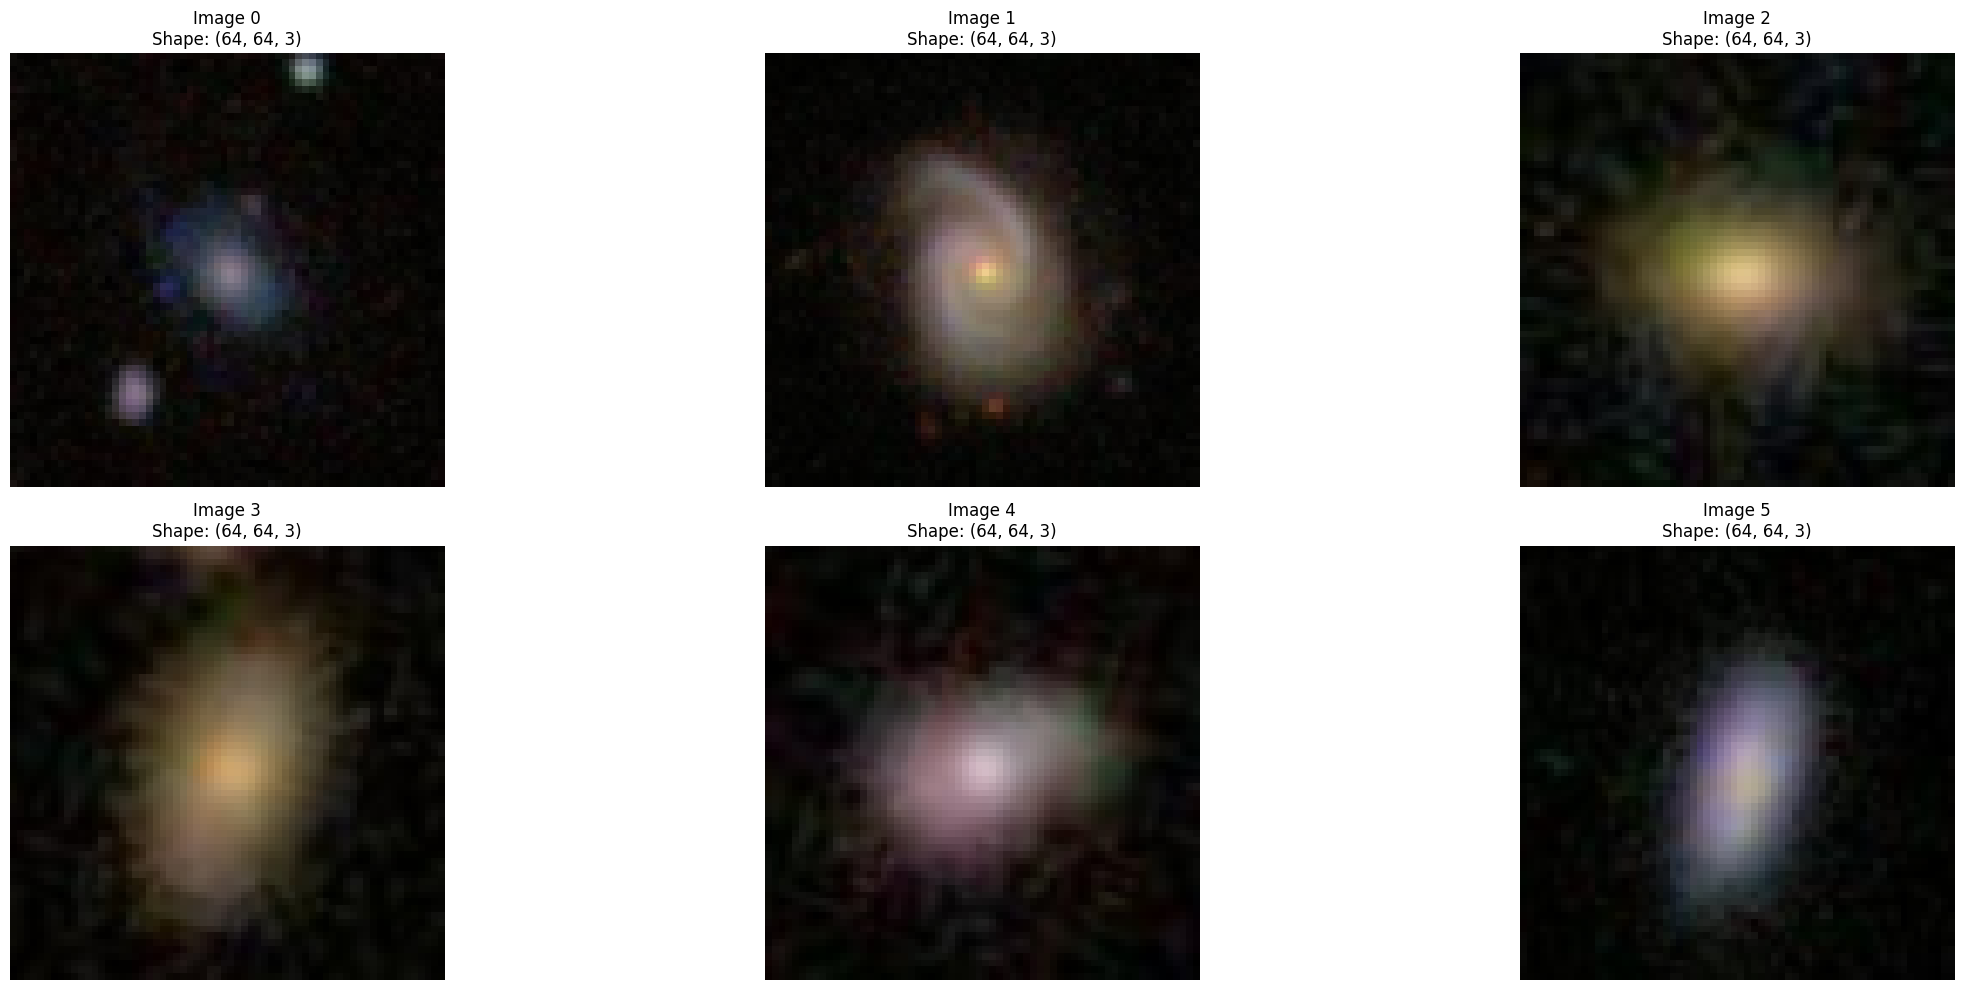

In [ ]:
print("Processed images")
plot_images_in_order(preprocessed_sample, 6)

Original images


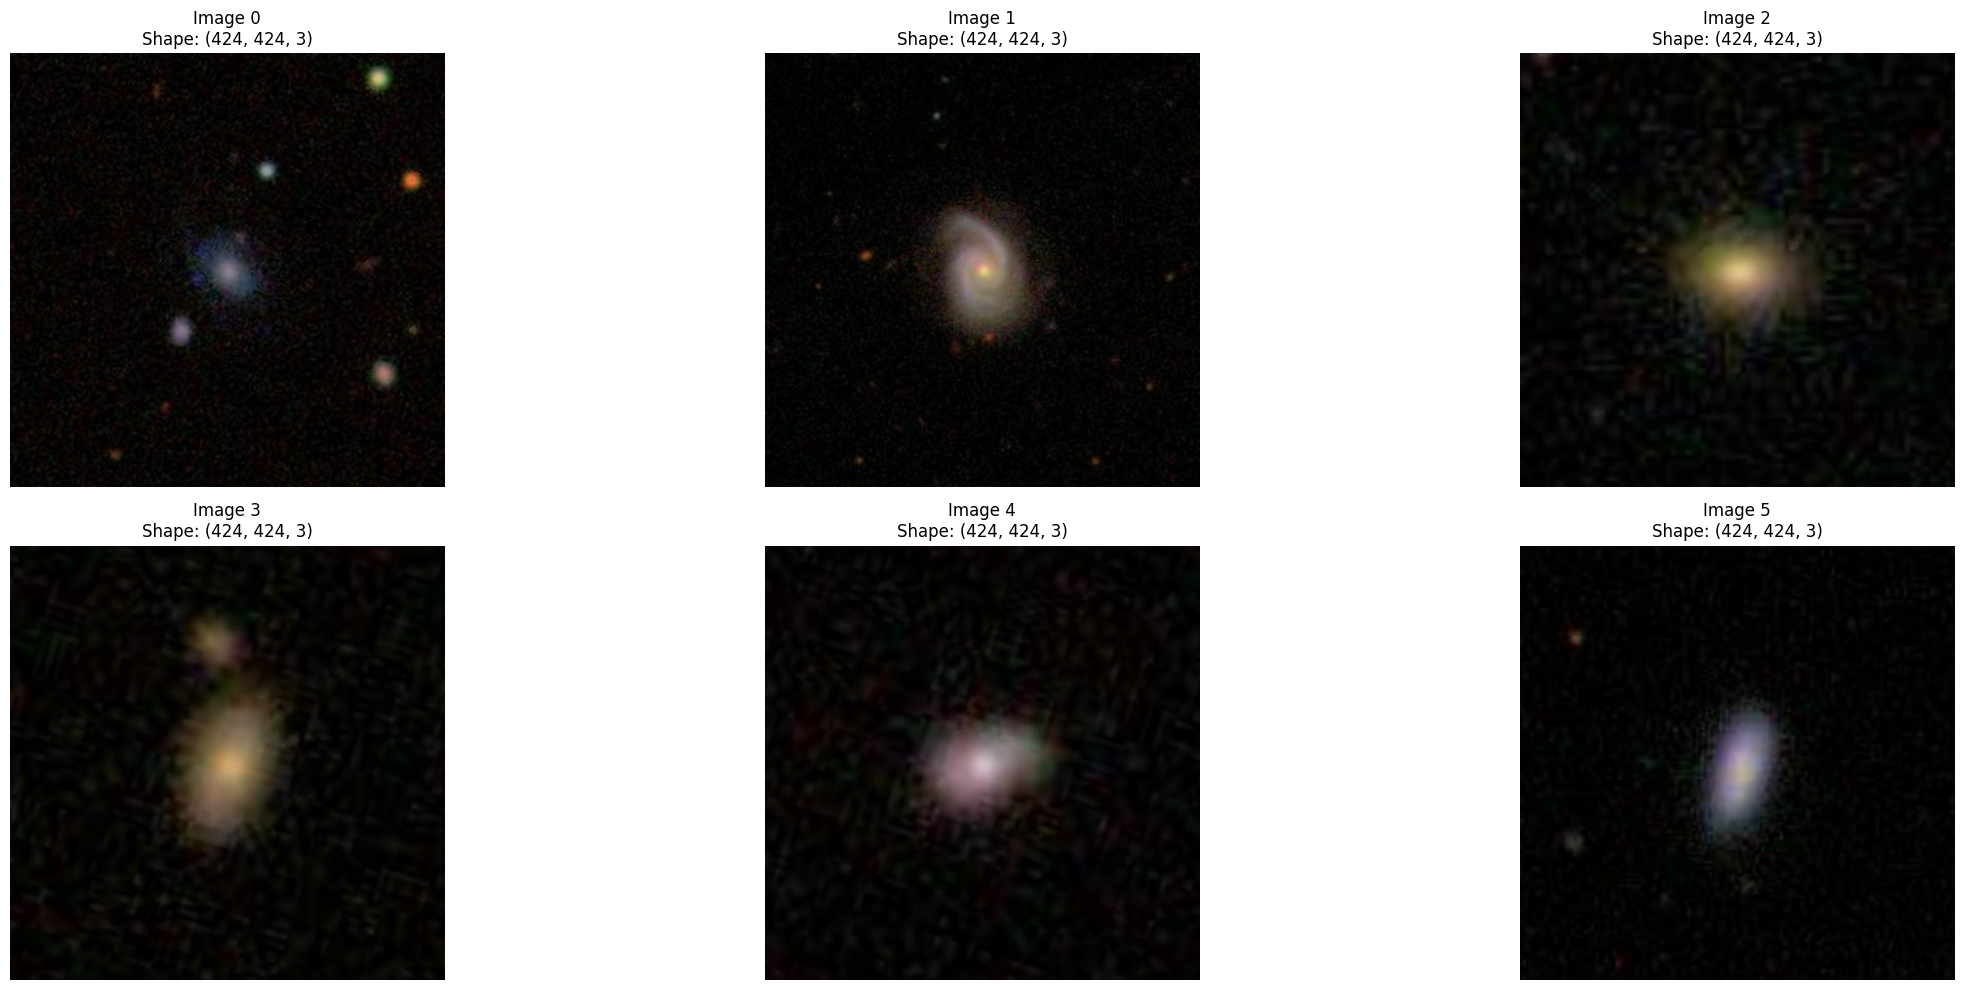

In [ ]:
print("Original images")
plot_images_in_order(original_sample, n=6)

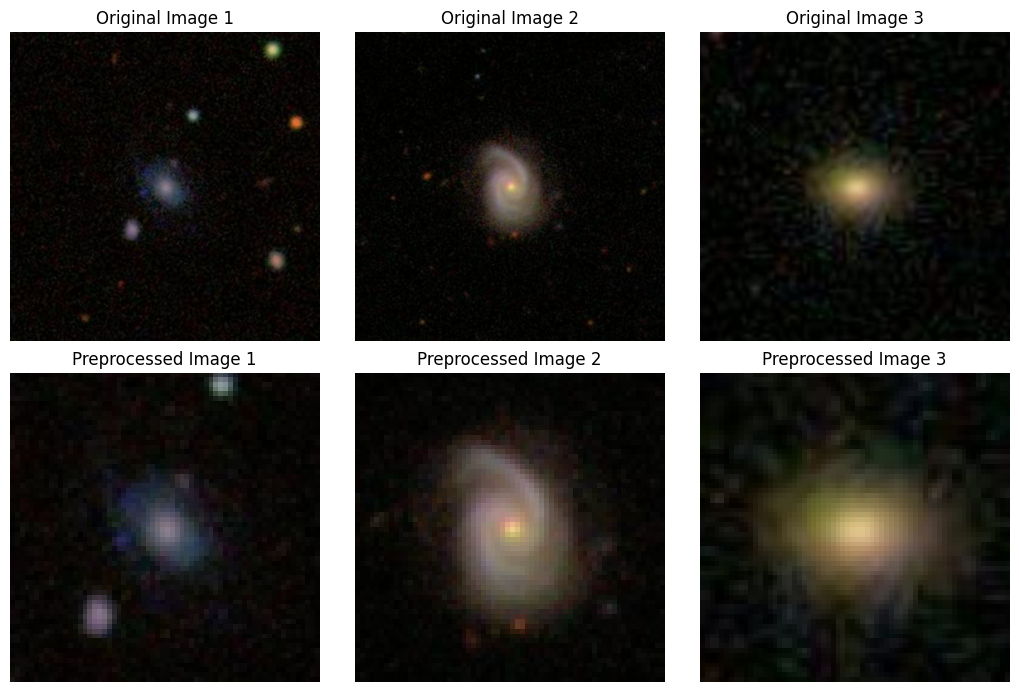

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(1, 7))
# Plot images from orig_sample in the first row
for i in range(3):
    axes[0, i].imshow(original_sample[i])
    axes[0, i].set_title(f'Original Image {i+1}')
    axes[0, i].axis('off')

# Plot images from preprocessed_sample in the second row
for i in range(3):
    axes[1, i].imshow(preprocessed_sample[i])
    axes[1, i].set_title(f'Preprocessed Image {i+1}')
    axes[1, i].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()